In [1]:
!pip install openpyxl

In [2]:
!pip install transformers

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 3

In [7]:
def get_data(path):
    df = pd.read_csv(path)
    df = df[['label', 'comment']]  # Only extract 'label' and 'comment' columns
    df.columns = ['emotion', 'comment']  # Rename 'label' column to 'emotion'
    return df

train_df = get_data('./normalized-train.csv')
valid_df = get_data('./normalized-dev.csv')
test_df = get_data('./normalized-test.csv')

# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.emotion)):
    train_df.loc[val_, "kfold"] = fold

<Axes: xlabel='emotion', ylabel='count'>

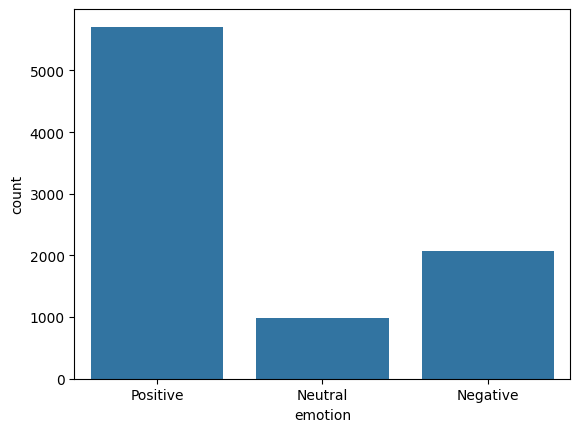

In [8]:
sns.countplot(x='emotion', data=train_df)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [10]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Positive':
            return 2
        elif text=='Neutral':
            return 1
        elif text=='Negative':
            return 0

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['comment']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['emotion'])

        return text, label

In [11]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [12]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [13]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [14]:
import shutil
import torch

for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            # Copy additional files


            best_acc = val_acc


-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/6
------------------------------
Train Accuracy: 0.7732329282902618 Loss: 0.6145190056108061
Valid Accuracy: 0.8151950718685832 Loss: 0.4680129257463367
Epoch 2/6
------------------------------
Train Accuracy: 0.824918706144104 Loss: 0.44126299168161354
Valid Accuracy: 0.8141683778234086 Loss: 0.46109797430983007
Epoch 3/6
------------------------------
Train Accuracy: 0.8550402190655485 Loss: 0.36867897988607484
Valid Accuracy: 0.8127994524298425 Loss: 0.5041677560351912
Epoch 4/6
------------------------------
Train Accuracy: 0.8819099777511552 Loss: 0.30822206063124813
Valid Accuracy: 0.8083504449007529 Loss: 0.5396386118290203
Epoch 5/6
------------------------------
Train Accuracy: 0.9075817217182953 Loss: 0.255786066765444
Valid Accuracy: 0.8032169746748802 Loss: 0.6004780336929475
Epoch 6/6
------------------------------
Train Accuracy: 0.9255519424952935 Loss: 0.21391171015687083
Valid Accuracy: 0.811772758384668 Loss: 0.6311631976051735
-----------Fold: 2 -------------

In [21]:
from huggingface_hub import HfApi
import os

print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir())

api = HfApi()

api.upload_file(
    path_or_fileobj="/content/phobert_fold3.pth",
    path_in_repo="phobert_fold4.pth",
    repo_id="Phanh2532/ViBERT-for-Sentimental-analysis",
    #repo_type="space",
)

Current directory: /content
Files in current directory: ['.config', 'normalized-train.csv', 'phobert_fold1.pth', 'normalized-dev.csv', 'train.csv', 'phobert_fold2.pth', 'remain-test.csv', 'remain-dev.csv', 'phobert_fold3.pth', 'test.csv', 'remain-train.csv', 'normalized-test.csv', 'sample_data']


phobert_fold3.pth:   0%|          | 0.00/540M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Phanh2532/ViBERT-for-Sentimental-analysis/commit/c6327bd07e010a068ffcebd35240acf4f60d86d3', commit_message='Upload phobert_fold4.pth with huggingface_hub', commit_description='', oid='c6327bd07e010a068ffcebd35240acf4f60d86d3', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [17]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       565
           1       0.33      0.14      0.19       218
           2       0.90      0.93      0.91      1404

    accuracy                           0.82      2187
   macro avg       0.65      0.63      0.63      2187
weighted avg       0.80      0.82      0.80      2187



In [16]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       565
           1       0.29      0.21      0.24       218
           2       0.91      0.91      0.91      1404

    accuracy                           0.82      2187
   macro avg       0.65      0.64      0.64      2187
weighted avg       0.80      0.82      0.81      2187



<Axes: >

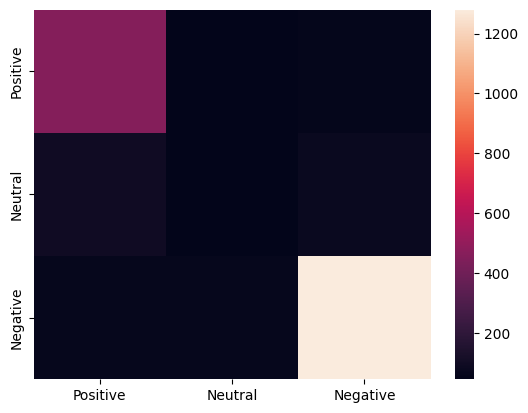

In [17]:
class_names = ['Positive', 'Neutral', 'Negative']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

In [18]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].comment)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
Mới sài để cặp đã nứt màn không lên nứt nên k có bảo hành thay màn gần bằng máy mới chán
Predicted: (Negative) --vs-- Real label: (Neutral)
--------------------------------------------------
Đang dùng 1 tháng ok. Sang tháng thư 2 bắt đau lỗi. Chán quá. Săp nguồn chết k lên dc. Lại còn cứ kêu tắt tình ắng chế tài nghe j ý
Predicted: (Neutral) --vs-- Real label: (Positive)
--------------------------------------------------
Mọi thứ ok.mình thấy pin trâu chứ có sao đâu.mua đc 2 tuần rồi chỉ có cảm biến vân tay ko nhạy như mong đợi thôi.
Predicted: (Neutral) --vs-- Real label: (Negative)
--------------------------------------------------
Máy mượt , dùng tốt  , pin ok chụp hình đẹp .. Mới mua về nên cần thời gian dùng tiếp
Predicted: (Positive) --vs-- Real label: (Neutral)
--------------------------------------------------
Máy quá kém chơi game thì giật giật máy mau nóng quá không hợp với giá 13 triệu đó giờ xài oppo không giờ mua samsung kg

In [19]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [20]:
infer('mình quá thất vọng về sam sung.dùng tháng 3 ngày hỏng mích thu mang đến tt bảo hành sửa lại phải chờ 2 ngày mới  lấy dk.', tokenizer)

Text: mình quá thất vọng về sam sung.dùng tháng 3 ngày hỏng mích thu mang đến tt bảo hành sửa lại phải chờ 2 ngày mới  lấy dk.
Sentiment: Negative


In [22]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl si

In [31]:
import torch
from transformers import AutoTokenizer
import gradio as gr
import torch.nn as nn
from transformers import AutoModel

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

# Load the trained model
model = SentimentClassifier(n_classes=7)
model.load_state_dict(torch.load("phobert_fold3.pth", map_location=torch.device('cpu')))
model.eval()

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

class_names = ['Positive', 'Neutral', 'Negative'vw]  # Define your class names here

# Define inference function
def infer(text, tokenizer=tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids']
    attention_mask = encoded_review['attention_mask']

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        _, y_pred = torch.max(output, dim=1)

    return f'Sentiment: {class_names[y_pred]}'

# Create Gradio interface
iface = gr.Interface(fn=infer, inputs="text", outputs="text", title="Sentiment Analysis")
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3f652235e4fb3583e4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
